# Bài 1: Thu thập lại dữ liệu về số ca nhiễm Corona ở từng quốc gia tại trang Worldometer

In [ ]:
from selenium.webdriver import Edge
from selenium.webdriver.edge.service import Service
from selenium.webdriver.edge.options import Options
from webdriver_manager.microsoft import EdgeChromiumDriverManager

edge_options = Options()
edge_options.add_experimental_option("detach", True)

# Lấy đường dẫn và in ra
driver_path = EdgeChromiumDriverManager().install()
print("Đường dẫn đến EdgeDriver:", driver_path)

# Khởi tạo trình duyệt
driver = Edge(service=Service(driver_path), options=edge_options)

Đường dẫn đến EdgeDriver: C:\Users\ADMIN\.wdm\drivers\edgedriver\win64\135.0.3179.54\msedgedriver.exe


## Load browser

In [23]:
from selenium.webdriver import Edge
from selenium.webdriver.edge.service import Service
from selenium.webdriver.edge.options import Options
# pip install selenium webdriver-manager
from webdriver_manager.microsoft import EdgeChromiumDriverManager # Import trình quản lý cho Edge để tự động cài webdriver nếu chưa có
import pandas as pd
import time
from selenium.webdriver.common.keys import Keys

url = "https://www.worldometers.info/coronavirus/#countries"

edge_options = Options()
edge_options.add_experimental_option("detach", True)

driver = Edge(service=Service(EdgeChromiumDriverManager().install()),
              options=edge_options)
driver.get(url)
time.sleep(2) 
driver.maximize_window()

In [24]:
# Xem tất cả các cột bị ẩn 
show_columns_xpath = '//*[@id="main_table_controls"]/ul/div/button'
show_columns_button = driver.find_element("xpath", show_columns_xpath)
show_columns_button.click()

In [25]:
# Click tất cả checkbox 
# features_xpath = f'/html/body/div[3]/div[3]/div/div[6]/ul/div/ul/li[2]/div/label/input'
features_xpath = f'/html/body/div[3]/div[3]/div/div[6]/ul/div/ul/li'
features_button = driver.find_elements("xpath", features_xpath)

for feature in features_button:
    try:
        checkbox = feature.find_element("xpath", ".//input")
        if not checkbox.is_selected():
            checkbox.click()
            time.sleep(0.5)
    except Exception as e:
        print(f"Lỗi với phần tử: {e}")

## Thêm cột cho Dataframe

In [26]:
# Lấy tên tất cả các cột 
xpath_col_query = '//table[@id="main_table_countries_today"]//thead/tr/th'
columns = driver.find_elements("xpath", xpath_col_query)

columns_name = [column.text for column in columns]
df = pd.DataFrame(columns=columns_name)

print(len(df.columns))
print(df.columns)

22
Index(['#', 'Country,\nOther', 'Total\nCases', 'New\nCases', 'Total\nDeaths',
       'New\nDeaths', 'Total\nRecovered', 'New\nRecovered', 'Active\nCases',
       'Serious,\nCritical', 'Tot Cases/\n1M pop', 'Deaths/\n1M pop',
       'Total\nTests', 'Tests/\n1M pop', 'Population', '',
       '1 Case\nevery X ppl', '1 Death\nevery X ppl', '1 Test\nevery X ppl',
       'New Cases/1M pop', 'New Deaths/1M pop', 'Active Cases/1M pop'],
      dtype='object')


## Thêm data vào trong dataframe

Ta cần kiểm tra các quốc gia có đủ 22 cột chưa, nếu có ta chấp nhận giả thuyết xpath để cào data trên là đúng, chúng ta sẽ kiểm tra lại ở sau, đề phòng cấu trúc HTML có thể thay đổi

In [27]:
# XPath query chung, placeholder {country} để lấy ra các quốc gia có @class="odd" hoặc @class="even" 
merged_countries = [
    ("USA", "odd"),
    ("India", "odd"),
    ("Germany", "odd"),
    ("Vietnam", "odd"),
    ("France", "even"),
    ("Brazil", "even"),
    ("Japan", "even"),
    ("UK", "even")
]

for country, row_class in merged_countries:
    data_square_xpath = f'//table[@id="main_table_countries_today"]//tbody/tr[@role="row" and @class="{row_class}"]/td/a[text()="{country}"]/ancestor::tr[1]/td'
    data_square_elements = driver.find_elements("xpath", data_square_xpath)
    print(f"Số lượng cột (td) của {country}: {len(data_square_elements)}")


Số lượng cột (td) của USA: 22
Số lượng cột (td) của India: 22
Số lượng cột (td) của Germany: 22
Số lượng cột (td) của Vietnam: 22
Số lượng cột (td) của France: 22
Số lượng cột (td) của Brazil: 22
Số lượng cột (td) của Japan: 22
Số lượng cột (td) của UK: 22


Bây giờ chúng ta sẽ đưa dữ liệu đã cào vào DataFrame. Tuy nhiên, do bảng chứa thể có các giá trị bị thiếu (missing value), một số ô <td> có thể rỗng. Vì vậy, ta cần lấy thuộc tính .text của từng phần tử <td> để đảm bảo rằng các ô dữ liệu trống vẫn được ghi nhận — nếu không, dữ liệu có thể bị lệch cột, khiến việc phân tích sau này không chính xác.

In [28]:
# Lấy tất cả các thẻ <td> từ cả dòng "odd" và "even"
td_elements = driver.find_elements(
    "xpath", '//table[@id="main_table_countries_today"]//tbody/tr[@role="row" and (@class="odd" or @class="even")]/td'
)

td_texts = [td.text for td in td_elements]
print(td_texts)

['1', 'USA', '111,820,082', '', '1,219,487', '', '109,814,428', '', '786,167', '940', '333,985', '3,642', '1,186,851,502', '3,544,901', '334,805,269', '', '3', '275', '0', '', '', '2,348', '2', 'India', '45,035,393', '', '533,570', '', 'N/A', 'N/A', 'N/A', 'N/A', '32,016', '379', '935,879,495', '665,334', '1,406,631,776', '', '31', '2,636', '2', '', '', '0.4', '3', 'France', '40,138,560', '', '167,642', '', '39,970,918', '', '0', '', '612,013', '2,556', '271,490,188', '4,139,547', '65,584,518', '', '2', '391', '0', '', '', '', '4', 'Germany', '38,828,995', '', '183,027', '', '38,240,600', '', '405,368', 'N/A', '462,891', '2,182', '122,332,384', '1,458,359', '83,883,596', '', '2', '458', '1', '', '', '4,833', '5', 'Brazil', '38,743,918', '', '711,380', '', '36,249,161', '', '1,783,377', 'N/A', '179,908', '3,303', '63,776,166', '296,146', '215,353,593', '', '6', '303', '3', '', '', '8,281', '6', 'S. Korea', '34,571,873', '', '35,934', '', '34,535,939', '', '0', '', '673,523', '700', '15,

In [29]:
# Kiểm tra xem tổng số <td> lấy được chia hết cho số cột = 22 không
if len(td_texts) % 22 != 0:
    print("Dữ liệu có thể bị thiếu hoặc lỗi cột!")
    print(f"Số lượng phần tử `<td>` lấy được: {len(td_texts)} (không chia hết cho 22)")
else:
    print("Dữ liệu hợp lệ, có thể tiếp tục xử lý...")

Dữ liệu hợp lệ, có thể tiếp tục xử lý...


Chia danh sách `td_texts` thành từng dòng (mỗi dòng 22 phần tử)

In [30]:
rows = [td_texts[i:i+22] for i in range(0, len(td_texts), 22)]

# Chuyển rows thành DataFrame tạm thời
new_data = pd.DataFrame(rows, columns=columns_name)

# Thêm vào DataFrame chính
df = pd.concat([df, new_data], ignore_index=True)

In [31]:
# Kiểm tra xem các trường đã ở định dạng mong muốn hay chưa
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231 entries, 0 to 230
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   #                    231 non-null    object
 1   Country,
Other       231 non-null    object
 2   Total
Cases          231 non-null    object
 3   New
Cases            231 non-null    object
 4   Total
Deaths         231 non-null    object
 5   New
Deaths           231 non-null    object
 6   Total
Recovered      231 non-null    object
 7   New
Recovered        231 non-null    object
 8   Active
Cases         231 non-null    object
 9   Serious,
Critical    231 non-null    object
 10  Tot Cases/
1M pop    231 non-null    object
 11  Deaths/
1M pop       231 non-null    object
 12  Total
Tests          231 non-null    object
 13  Tests/
1M pop        231 non-null    object
 14  Population           231 non-null    object
 15                       231 non-null    object
 16  1 Case
e

In [32]:
# Chuẩn hóa tên cột để dễ làm việc 
df.columns = df.columns.str.replace('\n', ' ').str.strip()

## a. Tìm 5 quốc gia có số ca nhiễm (Total case) nhiều nhất.

In [33]:
# Kiểm tra xem cột Total Cases có missing values không và loại missing gì (MCAR/MAR/MNAR)
print(df['Total Cases'].isnull().sum()) # Số mising values 
print(df['Total Cases'].unique()) # In ra các giá trị unique để đề phòng missing dưới dạng chuỗi rỗng [""]

0
['111,820,082' '45,035,393' '40,138,560' '38,828,995' '38,743,918'
 '34,571,873' '33,803,572' '26,723,249' '24,910,387' '24,124,215'
 '17,232,066' '13,914,811' '11,853,144' '11,625,195' '10,241,523'
 '10,128,845' '8,635,786' '7,702,809' '7,627,186' '6,829,221' '6,661,991'
 '6,400,173' '6,101,379' '6,081,287' '5,643,062' '5,557,995' '5,384,853'
 '5,278,406' '4,946,090' '4,861,695' '4,841,772' '4,772,813' '4,770,149'
 '4,759,041' '4,572,667' '4,453,053' '4,140,383' '4,076,463' '3,529,735'
 '3,183,756' '3,006,155' '2,937,609' '2,754,129' '2,621,111' '2,615,054'
 '2,465,545' '2,230,232' '2,049,377' '1,877,605' '1,861,665' '1,746,997'
 '1,734,582' '1,581,936' '1,516,117' '1,509,732' '1,411,831' '1,397,806'
 '1,356,546' '1,339,851' '1,309,728' '1,291,293' '1,278,992' '1,243,838'
 '1,238,883' '1,212,131' '1,153,361' '1,115,251' '1,070,188' '1,067,030'
 '1,059,893' '1,041,111' '1,011,496' '1,003,450' '994,037' '982,505'
 '841,469' '837,602' '835,234' '729,549' '681,110' '675,890' '672,754'
 

In [34]:
# Trước khi thực hiện, ta cần chuẩn hóa cột Total cases về dạng số nguyên để so sánh
# dùng .str.replace() để xóa dấu phẩy rồi mới ép kiểu số

df['Total Cases'] = df['Total Cases'].str.replace(',', '', regex=True).astype(float).astype('Int64')
print(df['Total Cases'].dtype)

Int64


**Top 5 Quốc gia có số ca nhiễm cao nhất là**

In [35]:
display(df.sort_values(by='Total Cases', ascending=False)[:5])

,#,"Country, Other",Total Cases,New Cases,Total Deaths,New Deaths,Total Recovered,New Recovered,Active Cases,"Serious, Critical",...,Total Tests,Tests/ 1M pop,Population,,1 Case every X ppl,1 Death every X ppl,1 Test every X ppl,New Cases/1M pop,New Deaths/1M pop,Active Cases/1M pop
0,1,USA,111820082,,"1,219,487",,"109,814,428",,"786,167",940,...,"1,186,851,502","3,544,901","334,805,269",,3,275,0,,,"2,348"
1,2,India,45035393,,"533,570",,N/A,N/A,N/A,N/A,...,"935,879,495","665,334","1,406,631,776",,31,"2,636",2,,,0.4
2,3,France,40138560,,"167,642",,"39,970,918",,0,,...,"271,490,188","4,139,547","65,584,518",,2,391,0,,,
3,4,Germany,38828995,,"183,027",,"38,240,600",,"405,368",N/A,...,"122,332,384","1,458,359","83,883,596",,2,458,1,,,"4,833"
4,5,Brazil,38743918,,"711,380",,"36,249,161",,"1,783,377",N/A,...,"63,776,166","296,146","215,353,593",,6,303,3,,,"8,281"


## b. Quốc gia nào có số ca nhiễm mới cao nhất?

In [36]:
# Kiểm tra missing value của cột New Cases
print(df['New Cases'].isnull().sum())
print(df['New Cases'].unique())  # Kiểm tra các giá trị duy nhất trong cột
print(df['New Cases'].dtype) # kiểm tra kiểu dữ liệu của dữ liệu trong cột 

0
['']
object


**Ta thấy mặc dù `.isnull().sum() = 0`, nhưng thật ra dữ liệu cột New Cases toàn bộ là chuỗi rỗng `['']` là 1 dạng missing nên ta cần chuyển nó về Nan**

In [37]:
import numpy as np
# Thay thế chuỗi rỗng bằng NaN
df['New Cases'].replace('', np.nan, inplace=True)

# Kiểm tra lại missing values
print(df['New Cases'].isnull().sum())  # Sẽ trả về số lượng giá trị missing
print(df['New Cases'].unique())  # Kiểm tra các giá trị duy nhất trong cột
print(df['New Cases'].dtype)

231
[nan]
float64


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_1276\2498966839.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['New Cases'].replace('', np.nan, inplace=True)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_1276\2498966839.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['New Cases'].replace(''

Khi thay thế giá trị chuỗi rỗng (`''`) bằng `NaN` trong một cột pandas, nếu cột ban đầu có kiểu dữ liệu là chuỗi (ví dụ, `object`), pandas sẽ tự động chuyển kiểu dữ liệu của cột thành `float64`. Điều này xảy ra vì `NaN` trong pandas là giá trị kiểu `float` (theo chuẩn IEEE 754 cho giá trị thiếu), và pandas sẽ ép kiểu toàn bộ cột để đồng nhất với kiểu dữ liệu của `NaN`, tức là `float64`.

**Vì toàn bộ dữ liệu trong cột "New Cases" bị thiếu (missing), việc tìm quốc gia có số ca nhiễm mới cao nhất sẽ dẫn đến kết quả không chính xác. Code dưới đây giả định dữ liệu không bị thiếu và tìm ra kết quả đúng.**

In [38]:
if df['New Cases'].notnull().any():  # Kiểm tra xem có dữ liệu hợp lệ trong cột không
    display(df[df['New Cases'] == df['New Cases'].max()])
else:
    print("Dữ liệu trong cột 'New Cases' bị thiếu hết.")

Dữ liệu trong cột 'New Cases' bị thiếu hết.


**Câu lệnh trên sẽ tìm và hiển thị quốc gia có số ca nhiễm mới cao nhất trong cột "New Cases". Khi cột này có nhiều giá trị missing (NaN), phương thức `.max()` sẽ bỏ qua các giá trị NaN và trả về giá trị lớn nhất trong các giá trị không thiếu. Do đó, nếu có quốc gia có dữ liệu hợp lệ, câu lệnh sẽ tìm ra quốc gia có số ca nhiễm mới cao nhất.**

## c. Tính tỉ lệ tổng số ca bình phục trên tổng số ca nhiễm. Xác định 3 quốc gia có tỉ lệ bình phục cao nhất. 

In [39]:
# Kiểm tra missing value trên cột Total recovered
print(df['Total Recovered'].isnull().sum())
print(df['Total Recovered'].unique())

0
['109,814,428' 'N/A' '39,970,918' '38,240,600' '36,249,161' '34,535,939'
 '26,361,218' '24,678,275' '23,545,818' '13,762,417' '11,820,014'
 '10,640,971' '10,222,518' '9,997,258' '8,612,599' '6,899,865' '6,647,104'
 '6,212,152' '6,054,934' '5,614,809' '5,445,577' '5,252,450' '5,233,268'
 '4,881,312' '4,826,798' '4,798,473' '4,772,739' '4,692,636' '4,715,206'
 '4,350,506' '4,438,309' '4,067,381' '3,912,506' '3,460,149' '3,174,942'
 '3,004,131' '2,916,005' '2,726,492' '2,613,791' '2,596,608' '2,439,497'
 '2,152,155' '1,856,381' '1,731,007' '1,724,921' '1,538,689' '1,503,989'
 '1,503,094' '1,383,020' '1,387,478' '1,349,424' '1,292,944' '1,258,432'
 '1,269,891' '1,087,587' '1,177,145' '1,106,660' '1,034,145' '1,051,102'
 '1,030,944' '1,009,212' '991,322' '985,592' '971,406' '824,089' '727,915'
 '679,745' '671,316' '655,852' '620,159' '615,445' '546,537' '442,182'
 '513,687' '500,835' '379,053' '488,171' '435,162' '379,084' '337,068'
 '341,316' '337,309' '243,601' '330,233' '327,049' '291,

**Ta thấy trong cột Total Recovered có giá trị missing - `N/A`**

=> Ta cần Investigate xem missing value trên thuộc loại gì để tìm phương án Impuse 

In [40]:
df.head(5)

,#,"Country, Other",Total Cases,New Cases,Total Deaths,New Deaths,Total Recovered,New Recovered,Active Cases,"Serious, Critical",...,Total Tests,Tests/ 1M pop,Population,,1 Case every X ppl,1 Death every X ppl,1 Test every X ppl,New Cases/1M pop,New Deaths/1M pop,Active Cases/1M pop
0,1,USA,111820082,NaN,"1,219,487",,"109,814,428",,"786,167",940,...,"1,186,851,502","3,544,901","334,805,269",,3,275,0,,,"2,348"
1,2,India,45035393,NaN,"533,570",,N/A,N/A,N/A,N/A,...,"935,879,495","665,334","1,406,631,776",,31,"2,636",2,,,0.4
2,3,France,40138560,NaN,"167,642",,"39,970,918",,0,,...,"271,490,188","4,139,547","65,584,518",,2,391,0,,,
3,4,Germany,38828995,NaN,"183,027",,"38,240,600",,"405,368",N/A,...,"122,332,384","1,458,359","83,883,596",,2,458,1,,,"4,833"
4,5,Brazil,38743918,NaN,"711,380",,"36,249,161",,"1,783,377",N/A,...,"63,776,166","296,146","215,353,593",,6,303,3,,,"8,281"


**Trước hết ta sẽ chuyển N/A về dạng missing values để tiện phân tích**

In [41]:
# Thay thế toàn bộ 'N/A' bằng NaN
df.replace('N/A', np.nan, inplace=True)
df.head(5)

,#,"Country, Other",Total Cases,New Cases,Total Deaths,New Deaths,Total Recovered,New Recovered,Active Cases,"Serious, Critical",...,Total Tests,Tests/ 1M pop,Population,,1 Case every X ppl,1 Death every X ppl,1 Test every X ppl,New Cases/1M pop,New Deaths/1M pop,Active Cases/1M pop
0,1,USA,111820082,NaN,"1,219,487",,"109,814,428",,"786,167",940,...,"1,186,851,502","3,544,901","334,805,269",,3,275,0,,,"2,348"
1,2,India,45035393,NaN,"533,570",,NaN,NaN,NaN,NaN,...,"935,879,495","665,334","1,406,631,776",,31,"2,636",2,,,0.4
2,3,France,40138560,NaN,"167,642",,"39,970,918",,0,,...,"271,490,188","4,139,547","65,584,518",,2,391,0,,,
3,4,Germany,38828995,NaN,"183,027",,"38,240,600",,"405,368",NaN,...,"122,332,384","1,458,359","83,883,596",,2,458,1,,,"4,833"
4,5,Brazil,38743918,NaN,"711,380",,"36,249,161",,"1,783,377",NaN,...,"63,776,166","296,146","215,353,593",,6,303,3,,,"8,281"


In [42]:
# Số lượng dòng thật sự missing 
print(df['Total Recovered'].isnull().sum())

47


**Bây giờ ta sẽ lấy tất cả các dòng bị missing ra xem xem có phát hiện được mối quan hệ gì không**

In [43]:
# Tạo cột flag cho missing
df_check = df.copy() # Tạo copy tránh tương tác trên df cũ 
df_check['missing_flag'] = df_check['Total Recovered'].isnull().astype(int)

print(df_check[['New Recovered', 'Active Cases', 'Serious, Critical']].dtypes)

New Recovered        object
Active Cases         object
Serious, Critical    object
dtype: object


In [44]:
# Chuyển các giá trị trống ("") hoặc không hợp lệ thành NaN trước khi tính trung bình:
df_check[['New Recovered', 'Active Cases', 'Serious, Critical']] = df_check[['New Recovered', 'Active Cases', 'Serious, Critical']].apply(pd.to_numeric, errors='coerce')

print(df_check[['New Recovered', 'Active Cases', 'Serious, Critical']].dtypes)


New Recovered        float64
Active Cases         float64
Serious, Critical    float64
dtype: object


**Sử dụng thống kê để kiểm tra xem loại missing values**

In [45]:
# Kiểm tra bằng groupby()
df_check.groupby('missing_flag')[['New Recovered', 'Active Cases', 'Serious, Critical']].mean()

,New Recovered,Active Cases,"Serious, Critical"
missing_flag,,,
0,164.8,179.613208,55.326923
1,NaN,NaN,NaN


**Phân tích dữ liệu thiếu trên cột Total Recovered**

Chúng ta quan sát thấy rằng khi cột Total Recovered bị thiếu (missing), thì các cột liên quan như: `New Recovered`, `Active Cases`, `Serious, Critical`  cũng có xu hướng bị thiếu dữ liệu theo. Điều này cho thấy các giá trị missing có cấu trúc — tức là chúng không xảy ra một cách ngẫu nhiên tuyệt đối.

=> Dữ liệu thiếu ít có khả năng thuộc loại MCAR (Missing Completely At Random).

---

**Giả thuyết về kiểu thiếu dữ liệu**

| Loại thiếu dữ liệu | Có khả năng? | Lý do |
|--------------------|--------------|-------|
| MCAR               | Thấp      | Vì dữ liệu thiếu có cấu trúc, thể hiện mối liên kết giữa các cột |
| MAR                | Cao       | Có thể giải thích missingness bằng các biến quan sát được (ví dụ: lấy số lượng total cases - death) |
| MNAR               | Có thể     | Nếu Total Recovered bị thiếu do bản thân nó (ví dụ: quốc gia không công bố dữ liệu phục hồi vì lý do chính trị) |


**Vì dữ liệu có được mô tả là: `As of April 13, 2024, the Coronavirus Tracker is no longer being updated due to the unfeasibility of providing statistically valid global totals` Và thời điểm này dịch covid cũng đã được kiểm soát, nên ta sẽ giả định Total Recovered = Total cases - Total Deaths** 

In [ ]:
# Loại bỏ dấu ',' và ép kiểu về số nguyên cho các cột liên quan
cols_to_convert = ['Total Deaths', 'Total Recovered']

for col in cols_to_convert:
    df[col] = df[col].replace('N/A', np.nan)                  # Nếu còn 'N/A' thì thay thành NaN
    df[col] = df[col].str.replace(',', '', regex=True)        # Xóa dấu phẩy
    df[col] = pd.to_numeric(df[col], errors='coerce')         # Ép kiểu về số, nếu lỗi thì thành NaN

# Bước 2: Tính Total Recovered nếu bị thiếu thì dùng Total Cases và Total Deaths
condition = df['Total Recovered'].isnull() & df['Total Cases'].notnull() & df['Total Deaths'].notnull()
df.loc[condition, 'Total Recovered'] = df['Total Cases'] - df['Total Deaths']


In [47]:
df[['Total Deaths', 'Total Recovered', 'Total Cases']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231 entries, 0 to 230
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Total Deaths     226 non-null    float64
 1   Total Recovered  230 non-null    float64
 2   Total Cases      231 non-null    Int64  
dtypes: Int64(1), float64(2)
memory usage: 5.8 KB


In [48]:
# Số lượng dòng thật sự missing 
# Vừa mất Total Recovered và mất thêm ít nhất 'Total Deaths', 'Total Recovered' nên không trừ được 
print(df['Total Recovered'].isnull().sum()) 

1


**3 quốc gia có tỉ lệ bình phục cao nhất**

In [49]:
df['percentage_recovered'] = df['Total Recovered'] / df['Total Cases']
print(df['percentage_recovered'].dtype)

Float64


In [50]:
display(df.sort_values(by='percentage_recovered', ascending=False)[:3])

,#,"Country, Other",Total Cases,New Cases,Total Deaths,New Deaths,Total Recovered,New Recovered,Active Cases,"Serious, Critical",...,Tests/ 1M pop,Population,,1 Case every X ppl,1 Death every X ppl,1 Test every X ppl,New Cases/1M pop,New Deaths/1M pop,Active Cases/1M pop,percentage_recovered
228,229,Vatican City,29,NaN,NaN,,29.0,,0,,...,,799,,28,,,,,,1.0
223,224,Falkland Islands,1930,NaN,NaN,,1930.0,,0,,...,"2,439,107","3,539",,2,,0,,,,1.0
31,32,DPRK,4772813,NaN,74.0,,4772739.0,,0,,...,,"25,990,679",,5,"351,225",,,,,0.999984


# Bài 2: Dùng lại API ở phần 2, viết chương trình thu thập dữ liệu về thời tiết

## Cách 1: Dùng tên thành phố 

In [51]:
import requests
from collections import defaultdict

def get_forecast_by_city(city_name):
    # Bình thường em sẽ để API_KEY trong file .env nhưng api này miễn phí và để tiện cho chạy code em sẽ hardcode api 
    API_KEY = 'efa08c442999dff743c4e4f78c695123' 
    city_query = city_name.replace(" ", "+")
    url = f'http://api.openweathermap.org/data/2.5/forecast?q={city_query}&appid={API_KEY}&units=metric&lang=vi'

    response = requests.get(url)
    data = response.json()

    if response.status_code == 200:
        print(f'Dự báo thời tiết 5 ngày tới tại {city_name}:\n')

        global pressure_by_day, wind_by_day
        pressure_by_day = defaultdict(list)
        wind_by_day = defaultdict(list)

        for forecast in data['list']:
            dt = forecast['dt_txt']
            day = dt.split(" ")[0]
            pressure = forecast['main']['pressure']
            wind_speed = forecast['wind']['speed']

            pressure_by_day[day].append(pressure)
            wind_by_day[day].append(wind_speed)

            temp = forecast['main']['temp']
            weather = forecast['weather'][0]['description']
            # print(f'{dt}: {temp}°C, {weather}, áp suất: {pressure} hPa, gió: {wind_speed} m/s')
    else:
        print(f'Không thể lấy dữ liệu dự báo cho {city_name}')


Dự báo thời tiết 5 ngày tới tại Saigon:



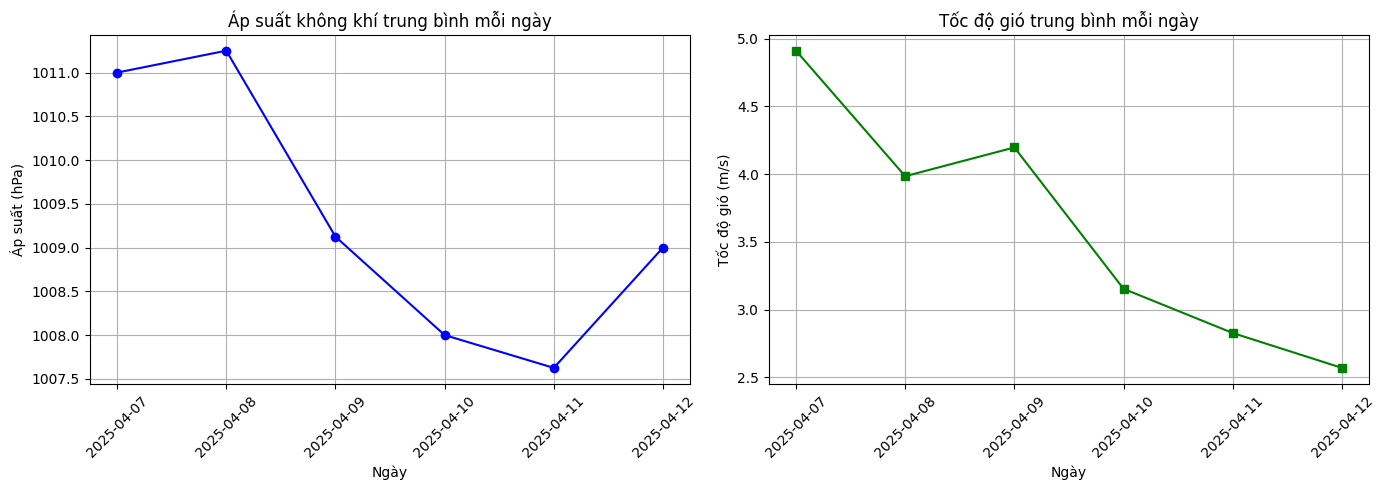

In [52]:
import matplotlib.pyplot as plt

def plot_two_metrics(pressure_dict, wind_dict):
    days = list(pressure_dict.keys())
    pressure_avg = [sum(values) / len(values) for values in pressure_dict.values()]
    wind_avg = [sum(values) / len(values) for values in wind_dict.values()]

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Biểu đồ áp suất
    axes[0].plot(days, pressure_avg, marker='o', color='blue')
    axes[0].set_title("Áp suất không khí trung bình mỗi ngày")
    axes[0].set_xlabel("Ngày")
    axes[0].set_ylabel("Áp suất (hPa)")
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(True)

    # Biểu đồ tốc độ gió
    axes[1].plot(days, wind_avg, marker='s', color='green')
    axes[1].set_title("Tốc độ gió trung bình mỗi ngày")
    axes[1].set_xlabel("Ngày")
    axes[1].set_ylabel("Tốc độ gió (m/s)")
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# Gọi hàm lấy dữ liệu
get_forecast_by_city("Saigon")

# Vẽ biểu đồ song song
plot_two_metrics(pressure_by_day, wind_by_day)

## Cách 2: Dùng tọa độ 

In [53]:
import requests
from collections import defaultdict
from datetime import datetime

def get_location():
    response = requests.get('https://ipinfo.io/json')  # Lấy thông tin tọa độ,...
    if response.status_code == 200:
        data = response.json()
        location = data['loc'].split(',')
        latitude = location[0]
        longitude = location[1]
        city = data['city']
        country = data['country']
        return latitude, longitude, city, country
    else:
        print("Đã xảy ra lỗi khi lấy thông tin vị trí")
        return None, None, None, None

def get_forecast_by_coords(lat, lon, city):
    # Bình thường em sẽ để API_KEY trong file .env nhưng api này miễn phí và để tiện cho chạy code em sẽ hardcode api 
    API_KEY = 'efa08c442999dff743c4e4f78c695123'
    url = f'http://api.openweathermap.org/data/2.5/forecast?lat={lat}&lon={lon}&appid={API_KEY}&units=metric&lang=vi'

    response = requests.get(url)
    data = response.json()

    global pressure_by_day, wind_by_day
    pressure_by_day = defaultdict(list)
    wind_by_day = defaultdict(list)

    if response.status_code == 200:
        print(f'Dự báo thời tiết 5 ngày tới tại {city}:\n')

        for forecast in data['list']:
            dt = forecast['dt_txt']
            day = dt.split(" ")[0]
            pressure = forecast['main']['pressure']
            wind_speed = forecast['wind']['speed']

            pressure_by_day[day].append(pressure)
            wind_by_day[day].append(wind_speed)

            temp = forecast['main']['temp']
            weather = forecast['weather'][0]['description']
            # print(f'{dt}: {temp}°C, {weather}, áp suất: {pressure} hPa, gió: {wind_speed} m/s')
    else:
        print(f'Không thể lấy dữ liệu dự báo cho vị trí {lat}, {lon}')

# Gọi xử lý
latitude, longitude, city, country = get_location()
if latitude and longitude:
    get_forecast_by_coords(latitude, longitude, city)

Dự báo thời tiết 5 ngày tới tại Ho Chi Minh City:



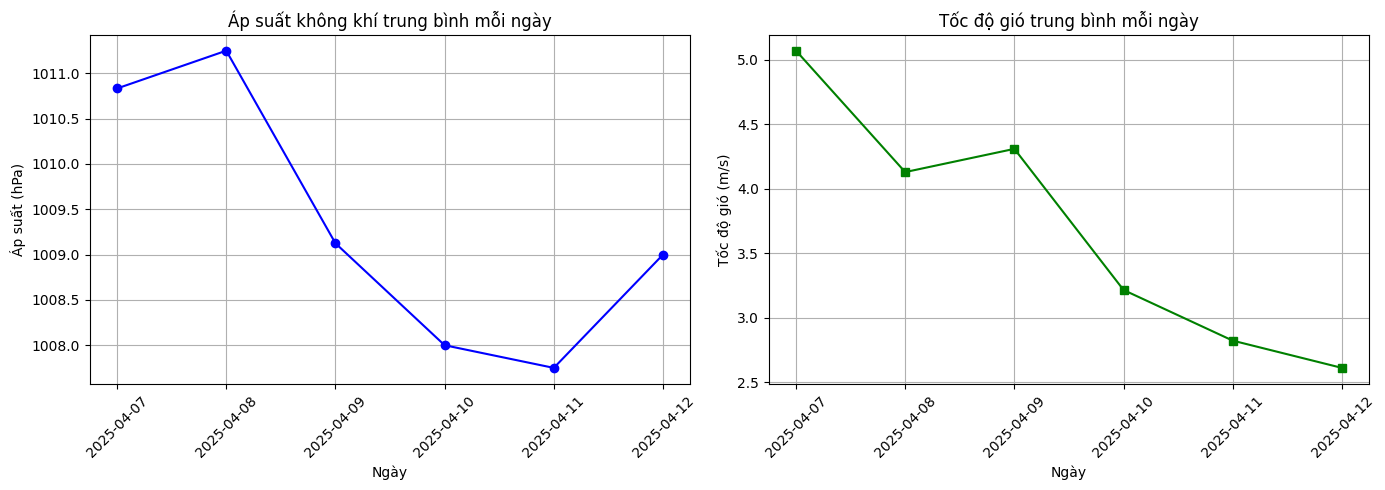

In [54]:
import matplotlib.pyplot as plt

def plot_two_metrics(pressure_dict, wind_dict):
    days = list(pressure_dict.keys())
    pressure_avg = [sum(values) / len(values) for values in pressure_dict.values()]
    wind_avg = [sum(values) / len(values) for values in wind_dict.values()]

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Biểu đồ áp suất
    axes[0].plot(days, pressure_avg, marker='o', color='blue')
    axes[0].set_title("Áp suất không khí trung bình mỗi ngày")
    axes[0].set_xlabel("Ngày")
    axes[0].set_ylabel("Áp suất (hPa)")
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(True)

    # Biểu đồ tốc độ gió
    axes[1].plot(days, wind_avg, marker='s', color='green')
    axes[1].set_title("Tốc độ gió trung bình mỗi ngày")
    axes[1].set_xlabel("Ngày")
    axes[1].set_ylabel("Tốc độ gió (m/s)")
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# Vẽ biểu đồ sau khi đã gọi hàm lấy dữ liệu
plot_two_metrics(pressure_by_day, wind_by_day)


# Bài 3: Sử dụng lại code thu thập dữ liệu từ Phần 3, viết chương trình gồm các chức năng sau

In [55]:
# Link CSV export từ Google Sheet
# https://docs.google.com/spreadsheets/d/1XEFg047aSbg3OsEVx9PzmgSxGbCvCidfLiHfsgRS3R0/edit?gid=0#gid=0
sheet_id = "1XEFg047aSbg3OsEVx9PzmgSxGbCvCidfLiHfsgRS3R0"
gid = "0"  # GID cho sheet đầu tiên

url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={gid}"
df = pd.read_csv(url)

display(df.head())

,Prefecture Patient Number,City Patient Number,Date Announced,Date Added,Age Bracket,Gender,"Residence City, Prefecture",Detected City,Detected Prefecture,Status,Notes,Source(s),Related Patients,Known Cluster,Deceased,MHLW (Orig) Patient Number,Charter Flight Passenger,Cruise Passenger (Disembarked),Has ID,Prefecture URL (Auto)
0,1,NaN,2020-01-30,2020-01-30,50,M,"Wuhan, China",NaN,Unspecified,Discharged,Japanese lives in China,https://www.mhlw.go.jp/stf/newpage_09531.html,NaN,Charter Flight,NaN,9,1.0,NaN,0.0,NaN
1,2,NaN,2020-02-01,2020-02-01,40,M,Unspecified,NaN,Unspecified,Discharged,NaN,https://www.mhlw.go.jp/stf/newpage_09531.html,3,Charter Flight,NaN,14,1.0,NaN,0.0,NaN
2,3,NaN,2020-02-01,2020-02-01,40,M,China,NaN,Unspecified,Discharged,Japanese lives in China,https://www.mhlw.go.jp/stf/newpage_09531.html,2,Charter Flight,NaN,15,1.0,NaN,0.0,NaN
3,4,Chiba#2,2020-02-01,2020-02-01,40,M,"Wuhan, China",NaN,Chiba,Discharged,Japanese lives in China,https://www.mhlw.go.jp/stf/newpage_09531.html,NaN,Charter Flight,NaN,16,1.0,NaN,2.0,NaN
4,5,ChibaAsymp#1,2020-01-30,2020-02-04,50,F,Chiba,NaN,Chiba,Discharged,NaN,https://www.mhlw.go.jp/stf/newpage_09531.html,NaN,Charter Flight,NaN,18,1.0,NaN,1.0,https://www.mhlw.go.jp/stf/newpage_09531.html


In [56]:
# Kiểm tra kiểu dữ liệu của df 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7006 entries, 0 to 7005
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Prefecture Patient Number       7006 non-null   object 
 1   City Patient Number             6643 non-null   object 
 2   Date Announced                  7006 non-null   object 
 3   Date Added                      7006 non-null   object 
 4   Age Bracket                     6761 non-null   object 
 5   Gender                          6784 non-null   object 
 6   Residence City, Prefecture      6261 non-null   object 
 7   Detected City                   3303 non-null   object 
 8   Detected Prefecture             7006 non-null   object 
 9   Status                          1274 non-null   object 
 10  Notes                           1794 non-null   object 
 11  Source(s)                       6855 non-null   object 
 12  Related Patients                12

## a. Liệt kê số ca nhiễm theo từng thành phố (Detected City).

In [57]:
# Detect missing values
print(f"Số mising value row: {df['Detected City'].isnull().sum()}")
print(f"Tỉ lệ mising values row: {df['Detected City'].isnull().sum()/len(df)}")

Số mising value row: 3703
Tỉ lệ mising values row: 0.5285469597487867




**Điều tra giá trị missing: Sử dụng Little’s MCAR Test để kiểm tra xem missing values có phải MCAR hay không**

- Bằng cách biến đổi các giá trị của cột `Detected City` thành các danh mục số liệu, ta có thể áp dụng Little’s MCAR Test cho cột này. Tuy nhiên, do dữ liệu của cột này ở dạng chuỗi, việc mã hóa (encode) chuỗi thành số sẽ khá phức tạp. 

- Vì vậy, ở đây chúng ta sẽ kiểm tra phân phối của các giá trị NULL trong tất cả các cột để xác định xem dữ liệu bị missing có phải là Missing Completely At Random (MCAR) hay không.

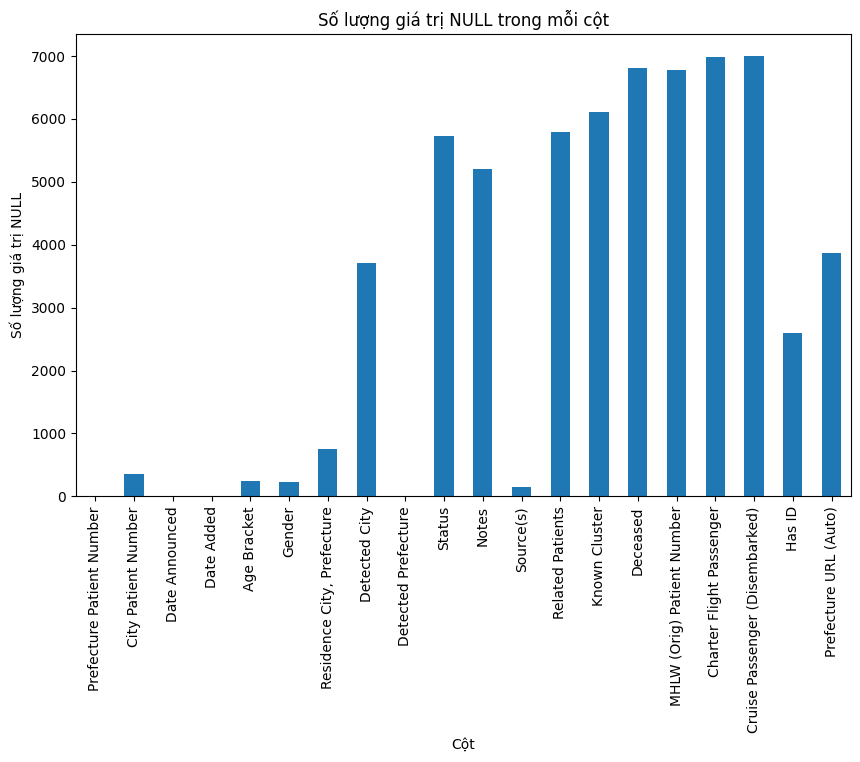

In [58]:
import matplotlib.pyplot as plt

# Tính số lượng giá trị NULL của mỗi cột
missing_values_count = df.isnull().sum()

# Tạo biểu đồ
plt.figure(figsize=(10, 6))
missing_values_count.plot(kind='bar')
plt.title('Số lượng giá trị NULL trong mỗi cột')
plt.xlabel('Cột')
plt.ylabel('Số lượng giá trị NULL')
plt.show()

**Phân tích tình trạng missing data:**

- Các cột có số lượng missing (dữ liệu bị thiếu) rất khác nhau, điều này cho thấy khả năng dữ liệu bị thiếu một cách hoàn toàn ngẫu nhiên (**MCAR**) là khá thấp.

- Số lượng giá trị missing chiếm tỉ lệ rất cao (hơn **52%**). Đồng thời, dường như biến **Detected City** là một biến rời rạc và không có mối quan hệ rõ ràng với các cột dữ liệu khác. Do đó, có khả năng cao rằng dữ liệu bị missing không phải do ngẫu nhiên (**MNAR** - Missing Not At Random).

- Với trường hợp này, sử dụng các phương pháp điền dữ liệu như **mô hình KNN** có thể không đảm bảo chính xác, vì bản chất dữ liệu bị missing ở đây không phải ngẫu nhiên. Nên ta sẽ drop NaN

In [59]:
print(df['Detected City'].isnull().sum())
# drop mising value
df = df.dropna(subset=['Detected City'])
print(df['Detected City'].isnull().sum())

3703
0


**Số ca nhiễm theo từng thành phố**

In [60]:
df['Detected City'].value_counts()

Detected City
Sapporo          188
Fukuoka City     101
Tonosho          100
Fukuoka city      96
Kyoto City        86
                ... 
Otawara            1
Nemuro             1
Nanae, Oshima      1
Kami               1
Atami              1
Name: count, Length: 474, dtype: int64

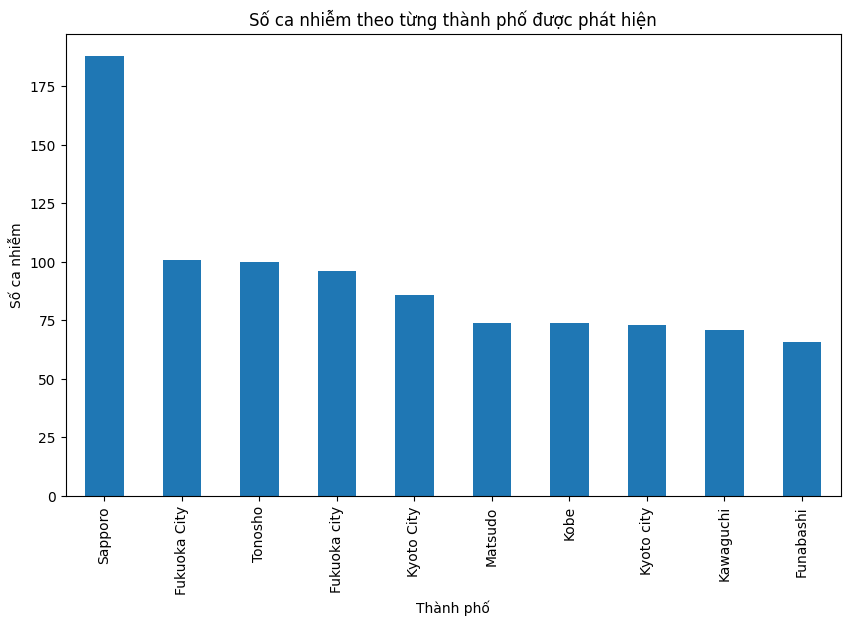

In [61]:
import matplotlib.pyplot as plt

city_counts = df['Detected City'].value_counts()[:10]  # Lấy 10 Tp nhiều nhất

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
city_counts.plot(kind='bar')
plt.title('Số ca nhiễm theo từng thành phố được phát hiện')
plt.xlabel('Thành phố')
plt.ylabel('Số ca nhiễm')
plt.show()

## b. Liệt kê số ca nhiễm theo độ tuổi, vẽ biểu đồ (sử dụng hàm plot).

In [62]:
# Đọc lại df vì trước đó drop mising cột Dêtcted values có thể thay đổi cột Age Bracket
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={gid}"
df = pd.read_csv(url)

# Detect missing values
print(f"Số mising value row: {df['Age Bracket'].isnull().sum()}")
print(f"Tỉ lệ mising values row: {df['Age Bracket'].isnull().sum()/len(df)}")

Số mising value row: 245
Tỉ lệ mising values row: 0.034970025692263776


In [63]:
age_bracket_counts = df['Age Bracket'].value_counts().reset_index()
age_bracket_counts.columns = ['Age Bracket', 'Count']
age_bracket_counts.T

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Age Bracket,50,40,20,30,60,70,80,10,90,0,...,Not public,100,Under10,-,elderly,Undisclosed,above 90,F,0ver 90,Unspecifed
Count,1232,1045,991,852,843,667,530,196,193,116,...,3,3,2,1,1,1,1,1,1,1


**Phân tích dữ liệu thiếu và phương pháp xử lý**

- **Tỉ lệ missing data:** Dữ liệu bị thiếu chiếm một tỉ lệ khá thấp (**3.4%**).

- **Cột `Age Bracket` không phải là MCAR:**  
  + Số lượng missing của cột này ít hơn nhiều so với các cột khác, cho thấy dữ liệu bị thiếu có thể liên quan đến một số biến cụ thể (MAR - Missing At Random).

- **Phân phối giá trị của cột `Age Bracket`:**  
  + Tuy cột `Age Bracket` có thể nhận 1 trong 25 phân loại nhưng dữ liệu đa phần tập trung vào 11 nhóm chính với tần suất cao, chiếm **99%** số dòng.

- **Phương pháp xử lý missing data:**  
  + Áp dụng kỹ thuật điền dữ liệu bằng **K-Nearest Neighbors (KNN)** để dự đoán các giá trị bị khuyết một cách hợp lý.

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Xử lý missing values
useful_columns = ['Gender', 'Residence City, Prefecture', 'Detected Prefecture']
df_useful = df[useful_columns + ['Age Bracket']]

# Bỏ các dòng chứa missing values trong các cột hữu ích
df_useful = df_useful.dropna(subset=useful_columns)

# Encode categorical features
label_encoders = {}
for col in useful_columns:
    le = LabelEncoder()
    df_useful[col] = le.fit_transform(df_useful[col])
    label_encoders[col] = le

# Tách dữ liệu thành phần đã biết và phần missing của 'Age Bracket'
df_known = df_useful[df_useful['Age Bracket'].notnull()]
df_unknown = df_useful[df_useful['Age Bracket'].isnull()]

# Encode age bracket
label_encoder_age = LabelEncoder()
df_known['Age Bracket'] = label_encoder_age.fit_transform(df_known['Age Bracket'])

# Chia tập train và test để đánh giá mô hình
X = df_known[useful_columns]
y = df_known['Age Bracket']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Chuẩn hóa số liệu
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Tạo và huấn luyện mô hình KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Dự đoán tập test và tính accuracy
y_pred = knn.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

# Dự đoán values missing trong cột 'Age Bracket'
if not df_unknown.empty:
    X_unknown = scaler.transform(df_unknown[useful_columns])
    predicted_age_bracket = label_encoder_age.inverse_transform(knn.predict(X_unknown))

    # Gán giá trị được dự đoán vào các dòng tương ứng trong df_unknown
    df.loc[df[df[useful_columns].notnull().all(axis=1) & df['Age Bracket'].isnull()].index, 'Age Bracket'] = predicted_age_bracket

Accuracy: 0.17128874388254486


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_1276\1459449915.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_known['Age Bracket'] = label_encoder_age.fit_transform(df_known['Age Bracket'])


**Phân tích dữ liệu thiếu và phương pháp xử lý:**

- **Độ chính xác của mô hình KNN:** Với độ chính xác chỉ đạt **17%**, phương pháp điền missing value bằng KNN không phù hợp.

- **Tỉ lệ missing data:** Dữ liệu bị thiếu chiếm một tỉ lệ khá thấp (**3.4%**).

**=> Quyết định xử lý missing data:**
- **Drop các dòng missing value:** Thay vì điền giá trị bị thiếu bằng KNN, ta sẽ loại bỏ các dòng có missing value để đảm bảo chất lượng của dữ liệu.

In [65]:
print(df['Age Bracket'].isnull().sum())
# drop mising value
df = df.dropna(subset=['Age Bracket'])
print(df['Age Bracket'].isnull().sum())

221
0


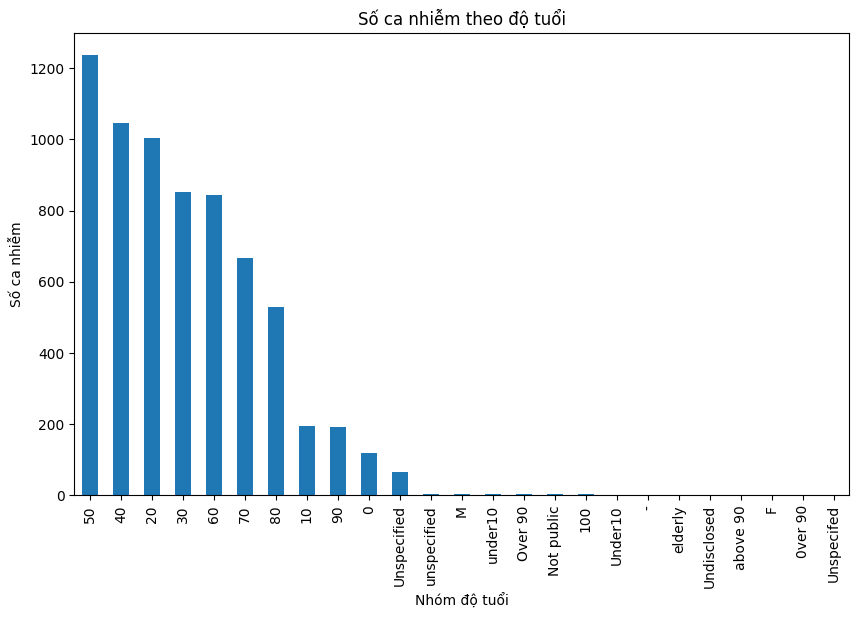

In [66]:
import matplotlib.pyplot as plt

# Liệt kê số ca nhiễm theo độ tuổi
age_counts = df['Age Bracket'].value_counts()  # Đếm số lượng các nhóm độ tuổi

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
age_counts.plot(kind='bar')
plt.title('Số ca nhiễm theo độ tuổi')
plt.xlabel('Nhóm độ tuổi')
plt.ylabel('Số ca nhiễm')
plt.show()

## c. Liệt kê số ca nhiễm tại Hokkaido theo từng ngày. Vẽ biểu đồ. 

In [67]:
# Đọc lại df vì các thao tác trước có thể làm thay đổi dataframe
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={gid}"
df = pd.read_csv(url)

# Kiểm tra mising values
print(df['Detected Prefecture'].isnull().sum())
print(df['Date Added'].isnull().sum())

0
0


**May thay cột `Detected Prefecture` và `Date Added` không có mising values**

In [68]:
# Chuyển data type cột Date Aded về biểu datetime
df['Date Added'] = pd.to_datetime(df['Date Added'], errors='coerce') # coerce chuyển giá trị không chuyển được thành NaT Not a time

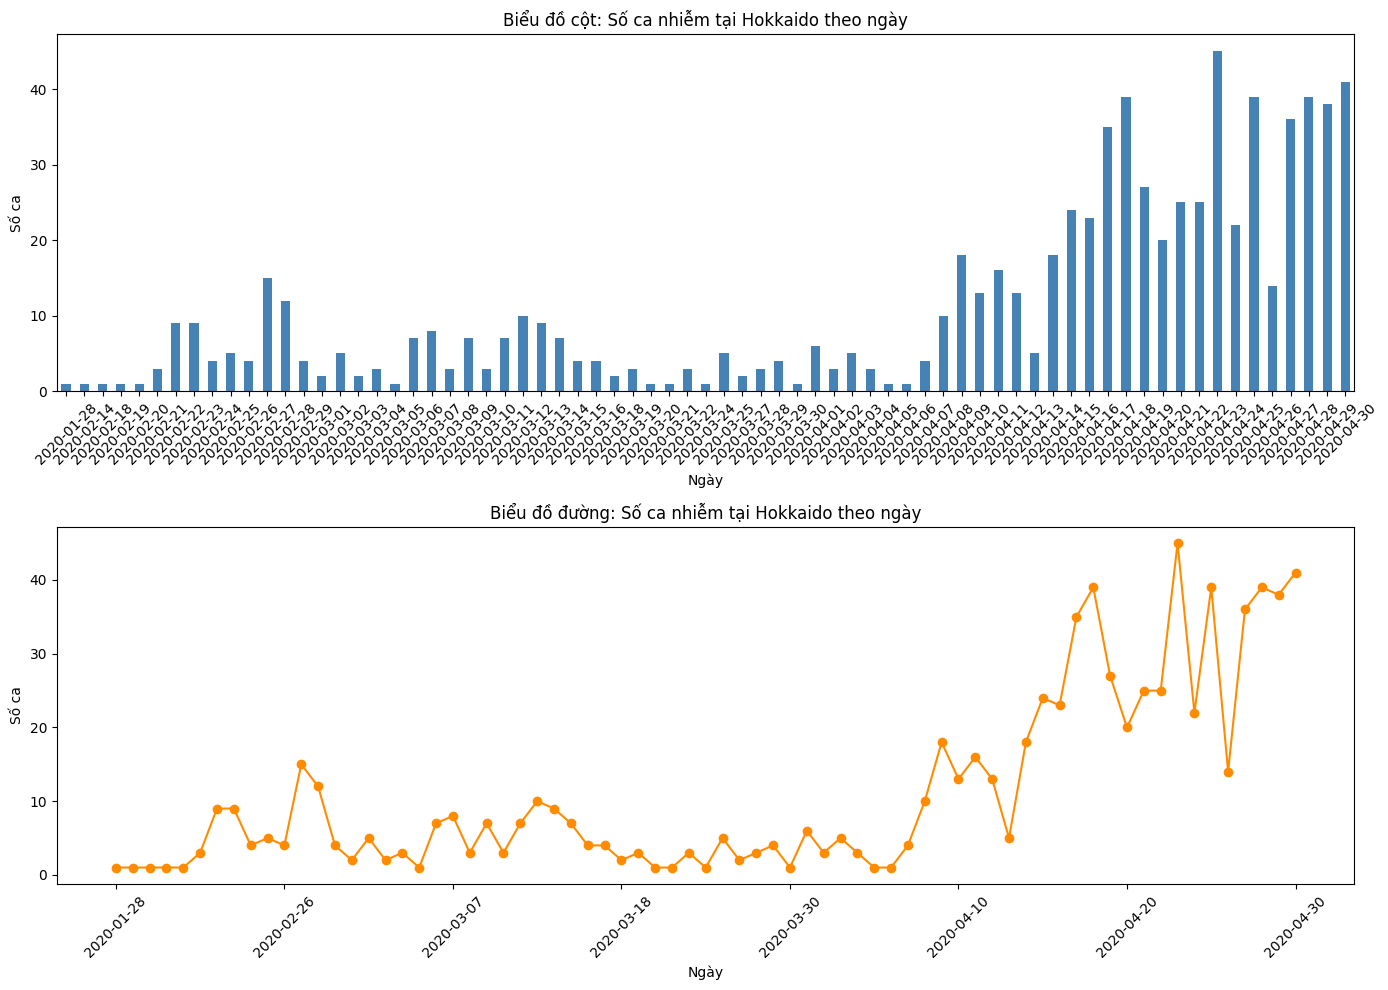

In [69]:
import matplotlib.pyplot as plt

# Lọc dữ liệu cho Hokkaido
hokkaido_df = df[df['Detected Prefecture'] == 'Hokkaido']

# Nhóm và đếm số ca theo ngày
cases_per_day = hokkaido_df.groupby('Date Announced').size()

# Tạo 2 subplot theo chiều dọc (1 cột, 2 hàng)
fig, axes = plt.subplots(2, 1, figsize=(14, 10)) # 2 hàng, 1 cột

# (1) Vẽ biểu đồ cột ở phía trên
cases_per_day.plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Biểu đồ cột: Số ca nhiễm tại Hokkaido theo ngày')
axes[0].set_xlabel('Ngày')
axes[0].set_ylabel('Số ca')
axes[0].tick_params(axis='x', rotation=45)

# (2) Vẽ biểu đồ đường ở phía dưới
cases_per_day.plot(kind='line', ax=axes[1], marker='o', color='darkorange')
axes[1].set_title('Biểu đồ đường: Số ca nhiễm tại Hokkaido theo ngày')
axes[1].set_xlabel('Ngày')
axes[1].set_ylabel('Số ca')
axes[1].tick_params(axis='x', rotation=45)

# Căn chỉnh bố cục tránh chồng lấn
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()